# Защита персональных данных клиентов

Нужно разработать метод шифрования данных, такой, чтобы качество модели машинного обучения (Линейной регрессии) не ухудшилось. Требуется обоснование корректности работы метода.

### Описание данных  
Признаки: личные данные клиентов страховой компании.  
Целевой признак: количество страховых выплат клиенту за последние 5 лет.

### План работы
1. [Загрузка и подготовка данных](#1.-Загрузка-и-подготовка-данных)
2. [Умножение матриц](#2.-Умножение-матриц)
3. [Алгоритм преобразования](#3.-Алгоритм-преобразования)
4. [Проверка алгоритма](#4.-Проверка-алгоритма)
5. [Общий вывод](#5.-Общий-вывод)

---

## 1. Загрузка и подготовка данных

In [1]:
#импортирование нужных библиотек:
import pandas as pd
import numpy as np
from numpy.linalg import inv

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

#визуализация
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

#игнорирование предупреждений
import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    data = pd.read_csv('/datasets/insurance.csv')
except:
    data = pd.read_csv('datasets/insurance.csv')

Исследуем данные:

In [3]:
def examine_df(df):
    display(df.head(10))
    display(df.info())
    display(df.describe())
    total = df.isnull().sum().sort_values(ascending=False)
    percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data.style.format('{:.1f}', subset='Percent')
    
    print(f'Количество пропусков {missing_data}')    
    print(f'Количество дубликатов : {df.duplicated().sum()} или {df.duplicated().sum() / df.shape[0]:.1%}')
    print('_____________________________________________')

In [4]:
examine_df(data)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
5,1,43.0,41000.0,2,1
6,1,39.0,39700.0,2,0
7,1,25.0,38600.0,4,0
8,1,36.0,49700.0,1,0
9,1,32.0,51700.0,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
Пол                  5000 non-null int64
Возраст              5000 non-null float64
Зарплата             5000 non-null float64
Члены семьи          5000 non-null int64
Страховые выплаты    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


None

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Количество пропусков                    Total  Percent
Страховые выплаты      0      0.0
Члены семьи            0      0.0
Зарплата               0      0.0
Возраст                0      0.0
Пол                    0      0.0
Количество дубликатов : 153 или 3.1%
_____________________________________________


Избавимся от дубликатов, их всего 3% от всех данных:

In [5]:
data.drop_duplicates(inplace=True)

Приведем столбцы к более подходящему типу:

In [6]:
col_to_int = ['Пол', 'Возраст', 'Зарплата', 'Страховые выплаты']
data[list(data.columns)] = data[list(data.columns)].astype('int64')


In [7]:
def visualize_df(df):
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 3))    
    fig.suptitle(f'Распределения признаков')
    palette = itertools.cycle(sns.color_palette())
    for col, ax in zip(['Возраст','Зарплата', 'Члены семьи'], axes.flat):
        color = next(palette)
        axes[0].set_ylabel('frequency')
        sns.distplot(df[col], color=color, ax=ax)
        fig.show()

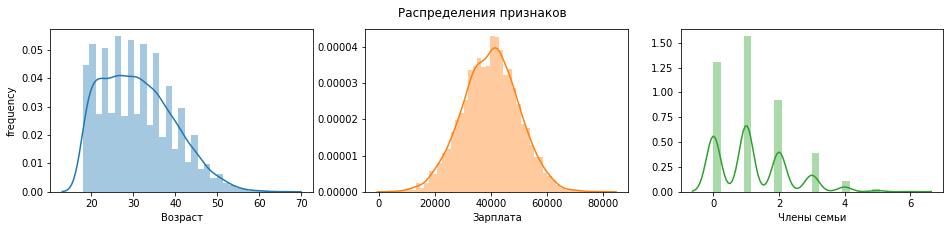

In [8]:
visualize_df(data)

### Вывод
Данные были изучены и подготовлены к дальнейшей работе.

## 2. Умножение матриц

Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? 


Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** 

Не изменится. Обратимая матрица сокращается, и задача сводится к исходной.

**Обоснование:** 

Будем пользоваться следующими правилами:  
$$
(AB)^{-1} = B^{-1} A^{-1} 
\label{eq:inv} \tag{1}
$$

$$
(AB)^T = B^T A^T
\label{eq:tr} \tag{2}
$$

$$
(A^T)^{-1} = (A^{-1})^T
\label{eq:inv_tr} \tag{3}
$$

$$
A^{-1} A = I
\label{eq:one} \tag{4}
$$

Задача линейной регрессии:
$$
a = X w = X (X^T X)^{-1} X^T y
\label{eq:lin_reg} \tag{*}
$$

Если умножим матрицу признаков на обратимую матрицу $P$:
$$
a = X P w  
$$

$$
w = ((X P)^T X P)^{-1} (X P)^T y
$$

тогда $a$:
$$
a = X P ((X P)^T X P)^{-1} (X P)^T y
$$

Воспользуемся $\eqref{eq:inv}$:
$$
a = X P (X P)^{-1} ((X P)^T)^{-1}  (X P)^T y 
$$

$$
= X P P^{-1} X^{-1} ((X P)^T)^{-1} (X P)^T y
$$
Согласно $\eqref{eq:one}$ $P P^{-1} = I$, воспользуемся $\eqref{eq:tr}$:
$$
= X X^{-1} ((P^T X^T)^{-1} P^T X^T y 
$$
и снова $\eqref{eq:inv}$:
$$
= X X^{-1} (X^T)^{-1} (P^T)^{-1} P^T X^T y 
$$

по $\eqref{eq:one}$:
$$
= X X^{-1} (X^T)^{-1} X^T y
$$
где по $\eqref{eq:inv}$ получаем:
$$
= X (X^T X)^{-1} X^T y
$$
что идентично $\eqref{eq:lin_reg}$ **q.e.d.**

## 3. Алгоритм преобразования

**Алгоритм**

1. Создадим матрицу 𝑃 со случайными числами по нормальному распределению
2. Проверим, что она получилась обратимой. Если нет, повторим генерацию, пока не получим обратимую матрицу.
3. Умножим матрицу признаков 𝑋 на матрицу 𝑃

In [9]:
def conversionAlg(X):
    success = False
    while success==False:
        P = np.random.normal(size=(X.shape[1], X.shape[1]))
        try:
            P_inv = np.linalg.inv(P)
            print(P_inv)
            success = True
        except np.linalg.LinAlgError:
            continue
    X_conv = X @ P
    return X_conv

**Обоснование**

Согласно пункту 2, умножение на обратимую матрицу не повлияет на нашу задачу.


## 4. Проверка алгоритма

Разобъем данные на признаки и целевой признак:

In [10]:
features = data.drop('Страховые выплаты', axis=1)
target = data['Страховые выплаты']

Отмасштабируем признаки:

In [11]:
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)

Преобразуем данные по нашему алгоритму:

In [12]:
features_conv = conversionAlg(features)

[[ 0.17946896 -0.33373629  0.38394793  1.00946095]
 [-0.30531076 -0.43024272 -0.45528184  0.89998094]
 [ 0.12683263  0.50130402  0.54342123 -0.05993818]
 [-0.49431358 -0.4456853   0.12606783  0.88775578]]


Проверим качество модели Линейной регрессии на исходных и преобразованных данных:

In [13]:
r2 = cross_val_score(LinearRegression(), features, target, cv=5, scoring='r2')
print(f'r2 для исходных данных: {r2}')
print(f'Средняя r2 для исходных данных: {r2.mean()}')

r2 для исходных данных: [0.3986062  0.4547181  0.42279282 0.41667654 0.44617763]
Средняя r2 для исходных данных: 0.42779425809789495


In [14]:
r2_conv = cross_val_score(LinearRegression(), features_conv, target, cv=5, scoring='r2')
print(f'r2 для преобразованных данных: {r2_conv}')
print(f'Средняя r2 для преобразованных данных: {r2_conv.mean()}')

r2 для преобразованных данных: [0.3986062  0.4547181  0.42279282 0.41667654 0.44617763]
Средняя r2 для преобразованных данных: 0.42779425809789495


## 5. Общий вывод

Преобразование данных посредством умножения на обратимую матрицу не повлияло на качество модели Линейной Регрессии.